# Imports

In [1]:
import datetime
import os

from matplotlib import pyplot as plt

# Data

In [ ]:
%%capture

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *

database.connect_dj(indicator='calcium')

In [3]:
rf_kind, fit_kind = database.get_default_rf_and_rf_fit_kind()
rf_morph_tab, rf_tab, morph_tab, cells = database.get_rf_and_morph_tab(roi_kind='roi', quality_filter=True)
field_rf_tab = database.get_rf_tab(roi_kind='field')

field_stack_pos_tab = database.get_field_stack_pos_tab()
roi_pos_tab = database.get_roi_pos_tab(stim_restriction=['stim_name="noise_1500"', 'stim_name="noise_2500"'])

In [4]:
df_field_rfs, field_avg_dx, field_avg_dy = database.get_field_avg_offset()
df_field_rfs.head(3)

experimenter   stim_name  raw_id    cond1  \
date       exp_num field                                             
2018-06-10 1       D1             Ran  noise_2500       1  control   
                   D2             Ran  noise_2500       1  control   
                   D3             Ran  noise_2500       1  control   

                          preprocess_id  dnoise_params_id  rf_glm_params_id  \
date       exp_num field                                                      
2018-06-10 1       D1                 1                 1                10   
                   D2                 1                 1                10   
                   D3                 1                 1                10   

                          split_rf_params_id  rf_contours_params_id  \
date       exp_num field                                              
2018-06-10 1       D1                      1                      1   
                   D2                      1                      1   
                   D3                      1                      1   

                          field_rf_dx_um  field_rf_dy_um  field_rf_d_um  
date       exp_num field                                                 
2018-06-10 1       D1            29.2784         7.05411        30.1162  
                   D2            54.2863        45.45800        70.8056  
                   D3            13.5319        22.08470        25.9007

# Plot

In [5]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [6]:
FIGURE_FOLDER = 'figures'

## sRF and morph

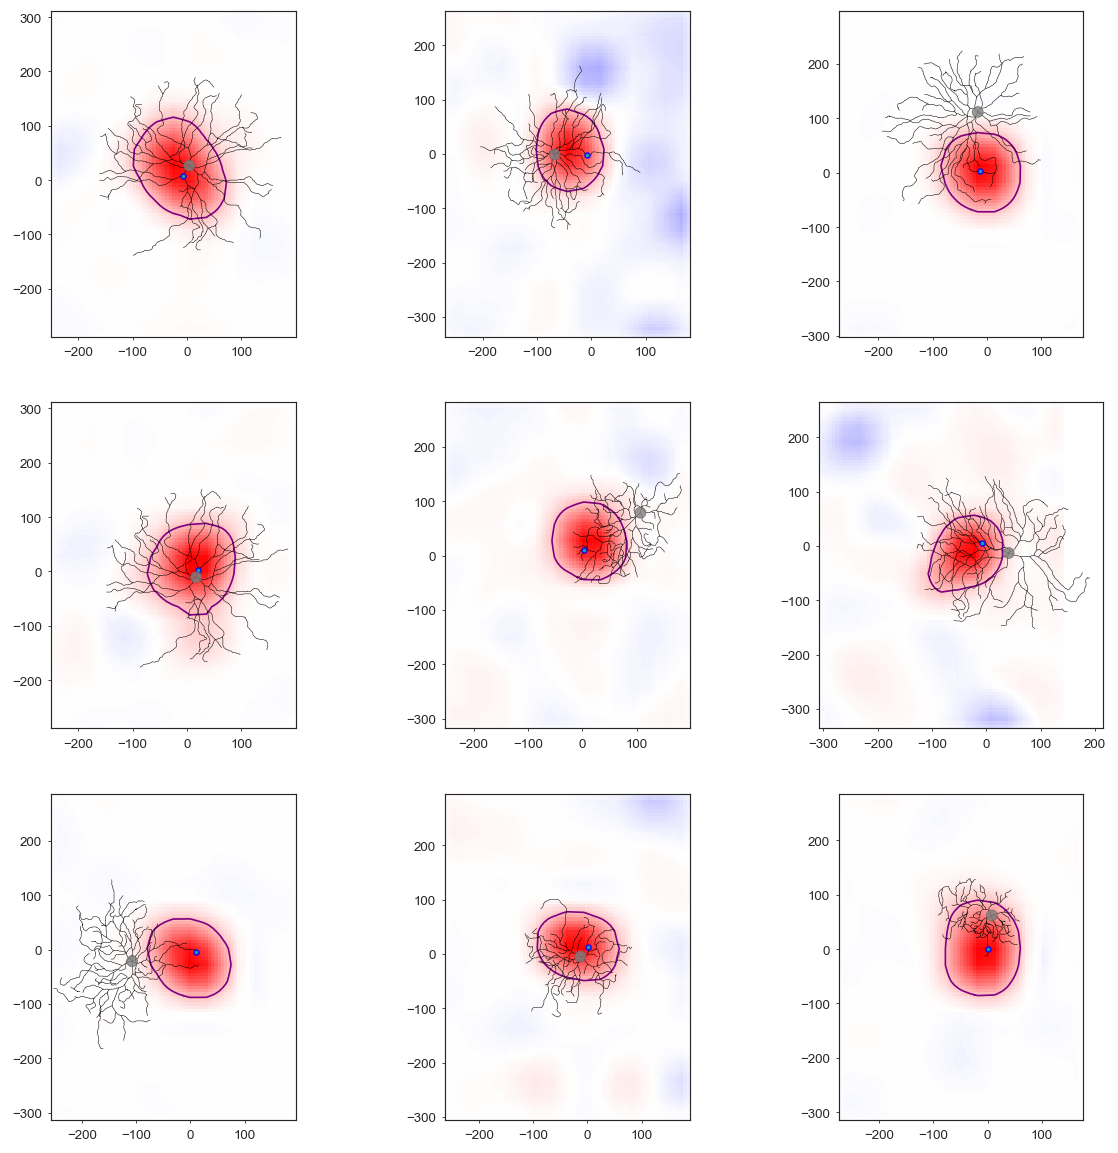

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()

keys = rf_morph_tab.fetch('KEY')
np.random.shuffle(keys)

for ax, key in zip(axs, keys):
    plota.fetch_and_plot_srf_and_morph(
        key, 'roi', fit_kind,
        rf_tab, morph_tab, field_stack_pos_tab, LineStack, Experiment, Field, FieldCalibratedStackPos,
        ax=ax, plot_center=False, plot_im=True, plot_outline=True, plot_morph=True, plot_roi=True,
        add_offset_rf=(-field_avg_dx.loc[(str(key['date']), key['exp_num'])],
                       -field_avg_dy.loc[(str(key['date']), key['exp_num'])]),
    )

## Plot all sRFs of example cell

In [8]:
def plot_field_fit_and_morph(pres_key, n_max=6):
    roi_ids, d_dist_to_soma = (rf_tab * roi_pos_tab & pres_key).fetch('roi_id', 'd_dist_to_soma')

    if len(roi_ids) > n_max:
        idxs = np.arange(len(roi_ids))
        np.random.shuffle(idxs)
        roi_ids = roi_ids[idxs[:n_max]]
        d_dist_to_soma = d_dist_to_soma[idxs[:n_max]]

    roi_ids = roi_ids[np.argsort(d_dist_to_soma)[::-1]]

    # Get Roi Mask
    roi_mask, npixartifact, ch_average, angle_deg = (
            Presentation * Presentation.ScanInfo * Presentation.RoiMask * (
                Presentation.StackAverages & dict(ch_name='wDataCh0')) & pres_key).fetch1(
        'roi_mask', 'npixartifact', 'ch_average', 'angle_deg')

    fig, axs = plt.subplots(2, len(roi_ids), figsize=(len(roi_ids) * 0.7, 1.3), height_ratios=(1, 1))

    for ax, roi_id in zip(axs[0, :], roi_ids):
        plota.plot_roi_mask_on_stack(ax, roi_mask, ch_average, roi_id, angle_deg, npixartifact)

    for ax in axs[1, :]:
        ax.set(xticks=[], yticks=[])

    plt.tight_layout(h_pad=0., w_pad=0.3, pad=0)

    for ax, roi_id in zip(axs[1, :], roi_ids):
        roi_key = pres_key.copy()
        roi_key['roi_id'] = roi_id

        plota.fetch_and_plot_srf_and_morph(
            roi_key, 'roi', fit_kind,
            rf_tab, morph_tab, field_stack_pos_tab, LineStack, Experiment, Field, FieldCalibratedStackPos,
            ax=ax, plot_center=False, plot_im=True, plot_outline=True, plot_morph=True, plot_roi=True,
            add_offset_rf=(-field_avg_dx.loc[(str(pres_key['date']), pres_key['exp_num'])],
                           -field_avg_dy.loc[(str(pres_key['date']), pres_key['exp_num'])]),
            fit_srf_xlim=True, srf_norm_kind='amp_one',
        )

    #for ax_col in axs.T:
    #    plota.align_box_left(ax=ax_col[0], ref_ax=ax_col[1])

    #plota.plot_scale_bar(axs[1, 0], x0=-90, y0=-190, size=100, pad=-10, text='100 µm', orientation='h')
    plota.plot_scale_bar(axs[1, 0], x0=60, y0=-280, size=100, pad=-10, text='', orientation='h')

    return fig, axs

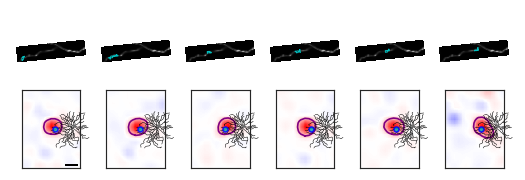

In [9]:
pres_key = {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1, 'stim_name': 'noise_1500',
            'field': 'd1'}
fig, axs = plot_field_fit_and_morph(pres_key)
pres_name = str(pres_key['date']) + '_' + str(pres_key['exp_num']) + '_' + str(pres_key['field']) + '_' + str(
    pres_key['stim_name'])
fig.savefig(os.path.join(FIGURE_FOLDER, f'example_rois_and_srf_{pres_name}.pdf'), bbox_inches='tight')

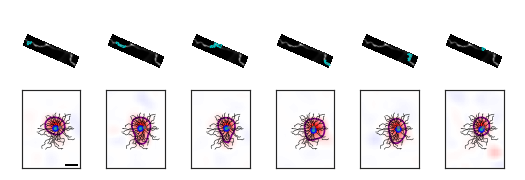

In [10]:
pres_key = {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1, 'stim_name': 'noise_1500',
            'field': 'd6'}
fig, axs = plot_field_fit_and_morph(pres_key)
pres_name = str(pres_key['date']) + '_' + str(pres_key['exp_num']) + '_' + str(pres_key['field']) + '_' + str(
    pres_key['stim_name'])
fig.savefig(os.path.join(FIGURE_FOLDER, f'example_rois_and_srf_{pres_name}.pdf'), bbox_inches='tight')

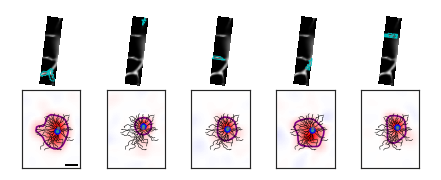

In [11]:
pres_key = {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1, 'stim_name': 'noise_1500',
            'field': 'd2'}
fig, axs = plot_field_fit_and_morph(pres_key)
pres_name = str(pres_key['date']) + '_' + str(pres_key['exp_num']) + '_' + str(pres_key['field']) + '_' + str(
    pres_key['stim_name'])
fig.savefig(os.path.join(FIGURE_FOLDER, f'example_rois_and_srf_{pres_name}.pdf'), bbox_inches='tight')

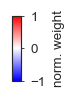

In [12]:
import matplotlib as mpl

fig, ax = plt.subplots(1, 1, figsize=(0.1, 0.7))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical', cmap='bwr', norm=norm, label='norm. weight')
plt.savefig(os.path.join(FIGURE_FOLDER, 'srf_colormap.pdf'), bbox_inches='tight')

## Plot Field RFs

In [13]:
def plot_field_rf_field_fit_and_morph(cell_key):
    field_keys = np.array((field_rf_tab & cell_key).fetch('KEY'))

    df_roi_pos = (roi_pos_tab & cell_key).proj('d_dist_to_soma').fetch(format='frame').reset_index()
    df_roi_pos.date = df_roi_pos.date.astype(str)
    df_means = df_roi_pos.groupby(['date', 'exp_num', 'field']).d_dist_to_soma.mean()

    d_dist_to_soma = np.array(
        [df_means.loc[(str(field_key['date']), field_key['exp_num'], field_key['field'][:2])] for field_key in
         field_keys])
    field_keys = field_keys[np.argsort(d_dist_to_soma)[::-1]]

    fig, axs = plt.subplots(2, len(field_keys), figsize=(len(field_keys) * 0.7, 1.3), height_ratios=(1, 1))

    for ax in axs[0, :]:
        ax.axis('off')

    for ax in axs[1, :]:
        ax.set(xticks=[], yticks=[])

    plt.tight_layout(h_pad=0., w_pad=0.3, pad=0)

    for ax, ax2, field_key in zip(axs[0, :], axs[1, :], field_keys):
        roi_mask, npixartifact, ch_average, angle_deg = (
                Presentation * Presentation.ScanInfo * Presentation.RoiMask * (
                    Presentation.StackAverages & dict(ch_name='wDataCh0')) & field_key).fetch1(
            'roi_mask', 'npixartifact', 'ch_average', 'angle_deg')
        plota.plot_roi_mask_on_stack(ax, roi_mask, ch_average, roi_id=1, angle_deg=angle_deg, npixartifact=npixartifact)

        center_roi_id = 1
        field_key["roi_id"] = center_roi_id
        plota.fetch_and_plot_srf_and_morph(
            field_key, 'field', fit_kind,
            field_rf_tab, morph_tab, field_stack_pos_tab, LineStack, Experiment, Field, FieldCalibratedStackPos,
            plot_center=False, plot_im=True, plot_outline=True, plot_morph=True, plot_roi=True,
            ax=ax2,
            add_offset_rf=(-field_avg_dx.loc[(str(cell_key['date']), cell_key['exp_num'])],
                           -field_avg_dy.loc[(str(cell_key['date']), cell_key['exp_num'])]),
            fit_srf_xlim=True,
        )

    #plota.plot_scale_bar(axs[1, 0], x0=-90, y0=-190, size=100, pad=-10, text='100 µm', orientation='h')
    plota.plot_scale_bar(axs[1, 0], x0=60, y0=-280, size=100, pad=-10, text='', orientation='h')

    return fig, axs

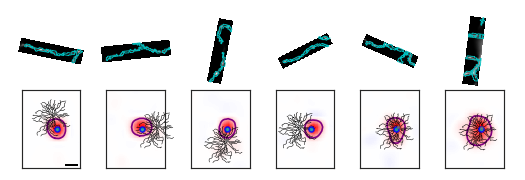

In [14]:
cell_key = {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1, 'stim_name': 'noise_1500'}
fig, axs = plot_field_rf_field_fit_and_morph(cell_key)

fig.savefig(os.path.join(FIGURE_FOLDER, f'example_field_rf.pdf'), bbox_inches='tight')